In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content="Hello, how can I assist you ?", name="Model")]
messages.append(HumanMessage(content="I'd like to cancel my subscription.", name="Swaraj"))
messages.append(AIMessage(content="I'm sorry to hear that. Please let me know if you need anything else.", name="Model"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

Hello, how can I assist you ?
================================ Human Message =================================
Name: Swaraj

I'd like to cancel my subscription.
================================== Ai Message ==================================
Name: Model

I'm sorry to hear that. Please let me know if you need anything else.


In [5]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [6]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [8]:
result.content

'I\'m sorry to hear that you\'re considering canceling your subscription. While I can provide general guidance, you\'ll need to follow the specific steps outlined by the service provider to cancel.\n\nTypically, the process involves:\n\n1. **Logging into your account**: Access the account management page on the service provider\'s website or app.\n   \n2. **Navigating to subscription settings**: Look for a section labeled "Subscriptions," "Billing," or "Account Management."\n\n3. **Canceling the subscription**: There should be an option to cancel your subscription. Follow the prompts, which may include confirming your cancellation.\n\n4. **Confirming cancellation**: Check for a confirmation email or message to ensure your subscription has been canceled.\n\nIf you run into any issues, I recommend reaching out to the provider\'s customer support for further assistance.'

In [10]:
result.response_metadata

{'token_usage': {'completion_tokens': 164,
  'prompt_tokens': 53,
  'total_tokens': 217,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_9bddfca6e2',
 'id': 'chatcmpl-BYCJECmkXkxG3sFw987r9FmSTM7RK',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

In [12]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [13]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [31]:
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EDfFmce7Wxi6Cn4jczcScw88', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 62, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9bddfca6e2', 'id': 'chatcmpl-BYCMlIOPsykxAVJFoXx3c86ZYnN0s', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--22e23141-d749-47ca-9188-9c028ad991b3-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_EDfFmce7Wxi6Cn4jczcScw88', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 17, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_rea

In [14]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_EDfFmce7Wxi6Cn4jczcScw88',
  'type': 'tool_call'}]

In [15]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [20]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [21]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

In [23]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='62a80e82-e28e-4274-b618-9e47d60ef74a'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='c19719e1-9b2d-4394-8a25-f7dae9e0ebfa')]

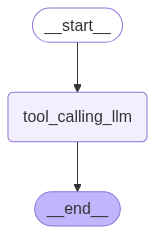

In [28]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
  return {"messages" : [llm_with_tools.invoke(state['messages'])]}

# add nodes
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm",tool_calling_llm)

# logic
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

# compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [30]:
messages = graph.invoke({"messages": HumanMessage(content="I want to multiply 8 and 20")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I want to multiply 8 and 20
================================== Ai Message ==================================
Tool Calls:
  multiply (call_joEmIUcxwNzWJ5HQROVA5HBa)
 Call ID: call_joEmIUcxwNzWJ5HQROVA5HBa
  Args:
    a: 8
    b: 20
